In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In this notebook, we train a CNN to detect the configuration of piecies on a chess board. The dataset consists of 80000 400x400 images of a chess board in 28 styles and with 5-15 pieces on it from one of 32 styles. The filename decribes the layout in standard PEN notation (pieces on each row, lower case is black, upper case is white, numbers indicate a number of consecutive empty squares). We could train a CNN on the images but it is probably more efficient to train a network on individual squares/pieces.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob

# View the data

List of files:

In [3]:
files=glob("*.jpeg",root_dir='/kaggle/input/chess-positions/train/')

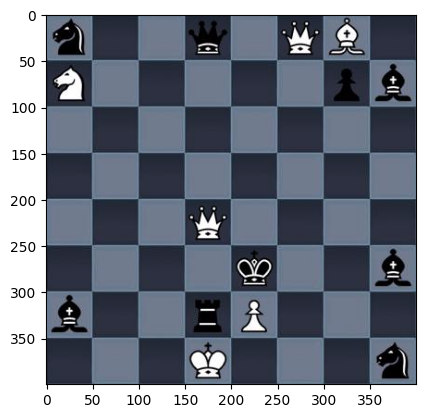

In [4]:
img=mpimg.imread('/kaggle/input/chess-positions/train/'+files[0])
plt.imshow(img);#note that the shape is 400x400x3
#print(img.dtype)

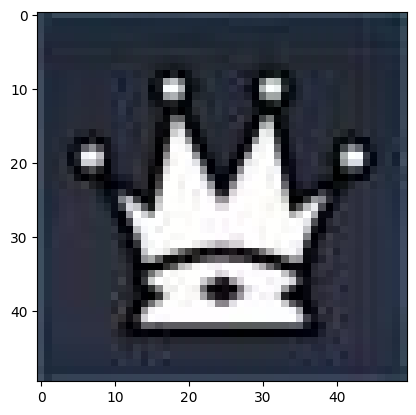

In [5]:
row=4
col=3
plt.imshow(img[row*50:(row+1)*50,col*50:(col+1)*50,:]);

# Parse the file names

In [6]:
PEN=files[0][:-5].split('-')
print(PEN)

['n2q1QB1', 'N5pb', '8', '8', '3Q4', '4k2b', 'b2rP3', '3K3n']


Let's explicitly write 0 for each empty square. This will make it easier to identifty the position of the pieces

In [7]:
d={'1':'0','2':'00','3':'000','4':'0000','5':'00000','6':'000000','7':'0000000','8':'00000000'}
trans_table=str.maketrans(d)
s=[item.translate(trans_table) for item  in PEN]
print(s)

['n00q0QB0', 'N00000pb', '00000000', '00000000', '000Q0000', '0000k00b', 'b00rP000', '000K000n']


And we invert the transformation as follows

In [8]:
for k, v in reversed(list(d.items())):
    s=[item.replace(v, k) for item in s]
s

['n2q1QB1', 'N5pb', '8', '8', '3Q4', '4k2b', 'b2rP3', '3K3n']

# Build a training set of individual squares 

Define a function to return a dictionary with the coordinates of each piece/space, taking only the first of each type for now

In [9]:
def parse_board(filename):
    output={}
    PEN=filename[:-5].split('-')
    for row in range(7):
        s=PEN[row].translate(trans_table)
        for pos, char in enumerate(s):
            #if char!='0':
            if char not in output:
                output[char]=(row,pos)
                #else:
                #    output[char].append((row,pos))
                
            #if char=='0':
             #   if char not in output:
             #       output[char]=[(row,pos)]
            #    elif len(output[char])<2:
           #         output[char].append((row,pos))
                
    return output

In [10]:
parse_board(files[0])

{'n': (0, 0),
 '0': (0, 1),
 'q': (0, 3),
 'Q': (0, 5),
 'B': (0, 6),
 'N': (1, 0),
 'p': (1, 6),
 'b': (1, 7),
 'k': (5, 4),
 'r': (6, 3),
 'P': (6, 4)}

Assemble the training set. Piece types (incl. empty squares) are mapped to ints. We take the same number of each piece type as the pieces occurs at different frequencies and in particular empty spaces far outnumber occupied spaces.

In [11]:
i=0
counts={'n':0,'N':0,'b':0,'B':0,'r':0,'R':0,'p':0,'P':0,'k':0,'K':0,'q':0,'Q':0,'0':0}
map_to_ints={'n':0,'N':1,'b':2,'B':3,'r':4,'R':5,'p':6,'P':7,'k':8,'K':9,'q':10,'Q':11,'0':12}
N=0

N_samples=13*5000

x_train=np.ndarray((N_samples,3,50,50),np.uint8)
y_train=np.ndarray((N_samples,),np.uint8)



while (N<N_samples) & (i<len(files)):
    dd=parse_board(files[i])
    img=mpimg.imread('/kaggle/input/chess-positions/train/'+files[i])
    for c in list(dd):
        if (counts[c]<N_samples/13) & (N<N_samples):
            row,col=dd[c]
            x_train[N,:,:,:]=img[row*50:(row+1)*50,col*50:(col+1)*50,:].transpose(2,0,1)
            y_train[N]=map_to_ints[c]
            N+=1
            counts[c]+=1
    i+=1
    
print(counts)

{'n': 5000, 'N': 5000, 'b': 5000, 'B': 5000, 'r': 5000, 'R': 5000, 'p': 5000, 'P': 5000, 'k': 5000, 'K': 5000, 'q': 5000, 'Q': 5000, '0': 5000}


In [12]:
i

16190

We only use a fraction of the data. However, there are 32 piece styles x 28 board styles x 2 square colours=1792 so we likely need several thousand samples for each piece type. 2000 is enough to get 99% accuracy but we take 5000 here.

In [13]:
y_train[:20]

array([ 0, 12, 10, 11,  3,  1,  6,  2,  8,  4,  7, 12,  4,  0,  2,  9,  3,
        0,  3, 12], dtype=uint8)

Define the reverse map from ints to characters

In [14]:
map_from_ints=dict((v, k) for k, v in map_to_ints.items())
x=[map_from_ints[k] for k in y_train[:20]]
print(x)

['n', '0', 'q', 'Q', 'B', 'N', 'p', 'b', 'k', 'r', 'P', '0', 'r', 'n', 'b', 'K', 'B', 'n', 'B', '0']


# Define the model

We use the a similar toplogy to the MNIST digits problem i.e. 2 convolutional layers and 2 fully connected layers

In [31]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # First 2D convolutional layer. Takes in the 3x50x50 images
      # outputting 32 convolutional features, with a square kernel size of 5
      self.conv1 = nn.Conv2d(3, 32, 5)
        
      # Second 2D convolutional layer, taking in the 32 input layers,
      # outputting 64 convolutional features, with a square kernel size of 5
      self.conv2 = nn.Conv2d(32, 64, 5)

      # Designed to ensure that adjacent pixels are either all 0s or all active
      # with an input probability
      self.dropout1 = nn.Dropout2d(0.25)
      self.dropout2 = nn.Dropout(0.5)

      # First fully connected layer
      self.fc1 = nn.Linear(5184, 128)
      # Second fully connected layer that outputs our 13 labels
      self.fc2 = nn.Linear(128, 13)
    
    def forward(self, x):

      x = self.conv1(x)               #Nx3x50x50 -> Nx32x46x46
      x = F.relu(x) 
      x = F.max_pool2d(x, 2)            ##Nx32x46x46 -> Nx32x23x23

      x = self.conv2(x)               #Nx32x23x23 -> Nx64x19x19
      x = F.relu(x)
      x = F.max_pool2d(x, 2)            ##Nx64x19x19 -> Nx64x9x9
        
      # Pass data through dropout1
      x = self.dropout1(x)
      # Flatten x with start_dim=1
      x = torch.flatten(x, 1)
      # Pass data through ``fc1``
      x = self.fc1(x)
      x = F.relu(x)
      x = self.dropout2(x)
      x = self.fc2(x)

      # Apply softmax to x
      #output = F.log_softmax(x, dim=1)# nn.CrossEntropyLoss() takes in logits
      return x#output

my_nn = Net()
print(my_nn)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=5184, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=13, bias=True)
)


Test the model first

In [18]:
input=torch.tensor(x_train[0,:,:,:],dtype=torch.float32)/255# convert to tensor of floats
input=torch.unsqueeze(input,0)#batch dimension
print(input.shape)
result = my_nn(input)
print(result)

torch.Size([1, 3, 50, 50])
tensor([[ 0.0643,  0.1380,  0.0898, -0.0663,  0.0880, -0.0248, -0.0247,  0.0348,
         -0.0008,  0.0043, -0.0408,  0.0023,  0.0649]],
       grad_fn=<AddmmBackward0>)


Set the optimizer

In [32]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_nn.parameters(), lr=0.001, momentum=0.9)

# Train the model

In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
my_nn.to(device)

cuda:0


Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=5184, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=13, bias=True)
)

In [10]:
n_epochs=30
accuracy_train=np.zeros(n_epochs,)
accuracy_test=np.zeros(n_epochs,)

In [11]:
batch_size=100

all_predictions=np.ndarray((N_samples,),dtype='int64')
#all_predictions_test=np.ndarray((x_test.shape[0],),dtype='int64')


for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in range(0,N_samples,batch_size):
        
        batch=torch.tensor(x_train[i:(i+batch_size),:,:,:],dtype=torch.float32).to(device)/255
        labels=torch.tensor(y_train[i:(i+batch_size)],dtype=torch.long).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = my_nn(batch)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        # print statistics
        running_loss += loss.item()
        if i% 20000 == 0:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            

#after each epoch, run again on the training and test data
    with torch.no_grad():
        for i in range(0,x_train.shape[0],batch_size):
            batch=torch.tensor(x_train[i:(i+batch_size),:,:,:],dtype=torch.float32).to(device)/255
            outputs = my_nn(batch)
            _, batch_predictions = torch.max(outputs.data, 1)
            all_predictions[i:(i+batch_size)]=batch_predictions.cpu().numpy()
        
        accuracy_train[epoch]=sum(y_train==all_predictions)/x_train.shape[0]
        
#         for i in range(0,x_test.shape[0],batch_size):
#             batch=torch.tensor(x_test[i:(i+batch_size),0,:,:],dtype=torch.float32).to(device)
#             batch=torch.unsqueeze(batch,1)
#             #labels=torch.tensor(y_train[i:(i+batch_size)],dtype=torch.long).to(device)
#             outputs = my_nn(batch)
#             _, batch_predictions = torch.max(outputs.data, 1)
#             all_predictions_test[i:(i+batch_size)]=batch_predictions.cpu().numpy()
#         accuracy_test[epoch]=sum(y_test==all_predictions_test)/x_test.shape[0]
    
    print(f'[{epoch + 1}, {i + 1:5d}] training accuracy: {accuracy_train[epoch]}')#, test accuracy: {accuracy_test[epoch]}')

print('Finished Training')

[1,     1] loss: 0.001
[1, 20001] loss: 0.240
[1, 40001] loss: 0.397
[1, 60001] loss: 0.481
[1, 64901] training accuracy: 0.15372307692307693
[2,     1] loss: 0.004
[2, 20001] loss: 0.088
[2, 40001] loss: 0.128
[2, 60001] loss: 0.153
[2, 64901] training accuracy: 0.4907692307692308
[3,     1] loss: 0.001
[3, 20001] loss: 0.033
[3, 40001] loss: 0.051
[3, 60001] loss: 0.061
[3, 64901] training accuracy: 0.6949384615384615
[4,     1] loss: 0.001
[4, 20001] loss: 0.016
[4, 40001] loss: 0.026
[4, 60001] loss: 0.033
[4, 64901] training accuracy: 0.8314615384615385
[5,     1] loss: 0.000
[5, 20001] loss: 0.010
[5, 40001] loss: 0.016
[5, 60001] loss: 0.021
[5, 64901] training accuracy: 0.8946615384615385
[6,     1] loss: 0.000
[6, 20001] loss: 0.007
[6, 40001] loss: 0.011
[6, 60001] loss: 0.015
[6, 64901] training accuracy: 0.9312461538461538
[7,     1] loss: 0.000
[7, 20001] loss: 0.005
[7, 40001] loss: 0.008
[7, 60001] loss: 0.011
[7, 64901] training accuracy: 0.9575384615384616
[8,     1] l

In [12]:
sum(y_train==all_predictions)/len(y_train)

0.9986153846153846

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


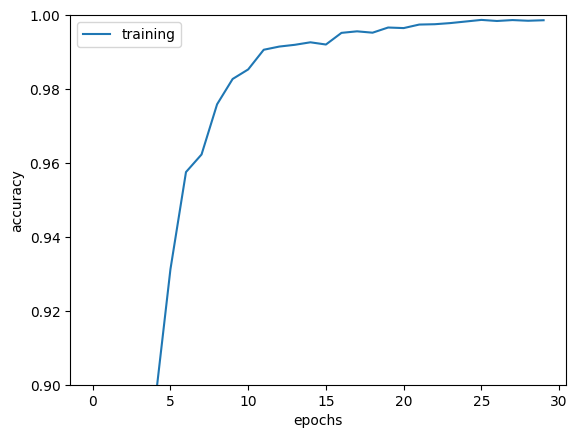

In [15]:
import seaborn as sns

ax=sns.lineplot(pd.DataFrame({'training':accuracy_train },index=range(n_epochs)));
ax.set_ylim(0.9,1);
ax.set_ylabel('accuracy');
ax.set_xlabel('epochs');

It looks like the accuracy on the training set has stabilised at 99.8%

In [17]:
#save the model
PATH = '/kaggle/working/my_nn.pth'
torch.save(my_nn.state_dict(), PATH)

In [ ]:
#load the model
PATH = '/kaggle/working/my_nn.pth'
my_nn = Net()
my_nn.load_state_dict(torch.load(PATH))

# Run the model on the test data

Let's run the model on the test data submitting each board/image as a batch and predicting the filename

In [18]:
test_files=glob("*.jpeg",root_dir='/kaggle/input/chess-positions/test/')

In [19]:
x_test=np.ndarray((64,3,50,50),np.uint8)

N_test=10000 # first N_test images

results=np.ndarray((N_test,),np.bool_)


for j in range(N_test):
    file=test_files[j]
    img=mpimg.imread('/kaggle/input/chess-positions/test/'+file)
    i=0
    for row in range(8):
        for col in range(8):
            x_test[i,:,:,:]=img[row*50:(row+1)*50,col*50:(col+1)*50,:].transpose(2,0,1)
            i+=1

    with torch.no_grad():
            batch=torch.tensor(x_test,dtype=torch.float32).to(device)/255
            outputs = my_nn(batch)
            _, batch_predictions = torch.max(outputs.data, 1)
            p=[map_from_ints[k] for k in batch_predictions.cpu().numpy()]
            s=[''.join(p[:8]),''.join(p[8:16]),''.join(p[16:24]),''.join(p[24:32]),''.join(p[32:40]),''.join(p[40:48]),''.join(p[48:56]),''.join(p[56:64])]        
            PEN='-'.join(s)
            for k, v in reversed(list(d.items())):
                PEN=PEN.replace(v, k)
            results[j]=file[:-5]==PEN
           # if results[j]==False:
            #    print(file[:-5],PEN)

In [20]:
sum(results)/len(results)

0.6523

A very poor result!
However an accuracy of 0.998 on individual squares means an accuracy 0.998^64=0.88 on an entire board so this is consistent.
An single square accuracy of 0.9999 would give a board accuracy of 0.994

Since training 2000 samples of each piece leads to much the same result as training 5000, the number of samples does not appear to be the bottleneck. It is possible that when the images in a batch come from different board styles, the model has trouble determining whether a piece or square is light/dark. There are darker styles and lighter styles and without the context, it is difficult to determine if a piece is a dark piece from a light style or a light piece from an overall dark style.

To overcome them, let's train each board as a single batch. In this way, each batch comes from the same board design and this may help the learning process.

# Re-train the model using boards as batches

Reset the model by running the definition, optimizer and to_device commands above

Train the model

In [34]:
map_to_ints={'n':0,'N':1,'b':2,'B':3,'r':4,'R':5,'p':6,'P':7,'k':8,'K':9,'q':10,'Q':11,'0':12}

N_samples=2000 # if there is an average of 10 pieces per board then 6000 samples gives 60,000 pieces (excl. empty squares), the same number as trained above.
#However, there are 54 empty spaces per board which gives 45*6000=270000 empty squares, which means 5 times the total number of images as the previous training
#lets try 2000 boards for now.

x_train=np.ndarray((64,3,50,50),np.uint8)
y_train=np.ndarray((64,),np.uint8)

all_predictions=np.ndarray((N_samples*64,),dtype='int64')
all_labels=np.ndarray((N_samples*64,),dtype='int64')


for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in range(0,N_samples):
        img=mpimg.imread('/kaggle/input/chess-positions/train/'+files[i])
        
        s=files[i][:-5].replace('-','').translate(trans_table)
        y_train=[map_to_ints[x] for x in s]
        
        j=0
        for row in range(8):
            for col in range(8):
                x_train[j,:,:,:]=img[row*50:(row+1)*50,col*50:(col+1)*50,:].transpose(2,0,1)
                j+=1
                
        batch=torch.tensor(x_train,dtype=torch.float32).to(device)/255
        labels=torch.tensor(y_train,dtype=torch.long).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = my_nn(batch)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        # print statistics
        running_loss += loss.item()
        if i% 2000 == 0:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            

#after each epoch, run again on the training and test data
    with torch.no_grad():
        for i in range(0,N_samples):
            img=mpimg.imread('/kaggle/input/chess-positions/train/'+files[i])
        
            s=files[i][:-5].replace('-','').translate(trans_table)
            y_train=[map_to_ints[x] for x in s]
            all_labels[64*i:(64*(i+1))]=y_train
        
            j=0
            for row in range(8):
                for col in range(8):
                    x_train[j,:,:,:]=img[row*50:(row+1)*50,col*50:(col+1)*50,:].transpose(2,0,1)
                    j+=1
                
            batch=torch.tensor(x_train,dtype=torch.float32).to(device)/255

            outputs = my_nn(batch)
            _, batch_predictions = torch.max(outputs.data, 1)
            all_predictions[64*i:(64*(i+1))]=batch_predictions.cpu().numpy()
            
        
        accuracy_train[epoch]=sum(all_labels==all_predictions)/all_labels.shape[0]
        

    
    print(f'[{epoch + 1}, {i + 1:5d}] training accuracy: {accuracy_train[epoch]}')

print('Finished Training')

[1,     1] loss: 0.001
[1,  2000] training accuracy: 0.9421484375
[2,     1] loss: 0.000
[2,  2000] training accuracy: 0.9752265625
[3,     1] loss: 0.000
[3,  2000] training accuracy: 0.989609375
[4,     1] loss: 0.000
[4,  2000] training accuracy: 0.994828125
[5,     1] loss: 0.000
[5,  2000] training accuracy: 0.9961640625
[6,     1] loss: 0.000
[6,  2000] training accuracy: 0.9975546875
[7,     1] loss: 0.000
[7,  2000] training accuracy: 0.9978984375
[8,     1] loss: 0.000
[8,  2000] training accuracy: 0.998390625
[9,     1] loss: 0.000
[9,  2000] training accuracy: 0.9983828125
[10,     1] loss: 0.000
[10,  2000] training accuracy: 0.9988671875
[11,     1] loss: 0.000
[11,  2000] training accuracy: 0.9989296875
[12,     1] loss: 0.000
[12,  2000] training accuracy: 0.9991953125
[13,     1] loss: 0.000
[13,  2000] training accuracy: 0.9991953125
[14,     1] loss: 0.000
[14,  2000] training accuracy: 0.9991953125
[15,     1] loss: 0.000
[15,  2000] training accuracy: 0.9993046875
[

Let's rerun on the test data

In [37]:
x_test=np.ndarray((64,3,50,50),np.uint8)

N_test=10000 # first N_test images

results=np.ndarray((N_test,),np.bool_)


for j in range(N_test):
    file=test_files[j]
    img=mpimg.imread('/kaggle/input/chess-positions/test/'+file)
    i=0
    for row in range(8):
        for col in range(8):
            x_test[i,:,:,:]=img[row*50:(row+1)*50,col*50:(col+1)*50,:].transpose(2,0,1)
            i+=1

    with torch.no_grad():
            batch=torch.tensor(x_test,dtype=torch.float32).to(device)/255
            outputs = my_nn(batch)
            _, batch_predictions = torch.max(outputs.data, 1)
            p=[map_from_ints[k] for k in batch_predictions.cpu().numpy()]
            s=[''.join(p[:8]),''.join(p[8:16]),''.join(p[16:24]),''.join(p[24:32]),''.join(p[32:40]),''.join(p[40:48]),''.join(p[48:56]),''.join(p[56:64])]        
            PEN='-'.join(s)
            for k, v in reversed(list(d.items())):
                PEN=PEN.replace(v, k)
            results[j]=file[:-5]==PEN
           # if results[j]==False:
            #    print(file[:-5],PEN)

In [38]:
sum(results)/len(results)

0.9811

We get a much better board test accuracy of 98%, consistent with the single square test accuracy 0.9997^64=0.98. If we train on all 80000 test images (rathen than only 2000), the accuracy will likely improve further but we would likely need to rerun for fewer epochs for computational reasons.